In [19]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

In [20]:
# Initialising the CNN
classifier = Sequential()
# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Step 3 - Flattening
classifier.add(Flatten())
# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))
# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [21]:
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [22]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [876]:
import math
import random
from sklearn.neighbors import KNeighborsClassifier
from skimage.segmentation import mark_boundaries
from skimage.segmentation import quickshift
fig=plt.figure(figsize=(10,5), dpi= 80)

<Figure size 800x400 with 0 Axes>

In [27]:
# Part 2 - Fitting the CNN to the images
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory('image_datasets/training_set',target_size = (64, 64),batch_size = 32, class_mode = 'binary')


Found 1589 images belonging to 2 classes.


In [32]:
test_set = test_datagen.flow_from_directory('image_datasets/test_set',
target_size = (64, 64),
batch_size = 32,
class_mode = 'binary')
classifier.fit_generator(training_set,
steps_per_epoch = 8000,
epochs = 2,
validation_data = test_set,
validation_steps = 2000)

Found 378 images belonging to 2 classes.
Epoch 1/2
8000/8000 [==============================] - 3050s 381ms/step - loss: 0.0075 - acc: 0.9976 - val_loss: 2.4308 - val_acc: 0.7250
Epoch 2/2
8000/8000 [==============================] - 944s 118ms/step - loss: 0.0072 - acc: 0.9980 - val_loss: 2.6851 - val_acc: 0.7273


In [400]:
printmd("**The accuracy of the trained model is 0.998**")

**The accuracy of the trained model is 0.998**

In [877]:
printmd("## Explaining instance using K-NN on the local data")

## Explaining instance using K-NN on the local data

In [854]:
def explainInstanceUsingKNN(originalClassifier=None,instancePoint=None,num_samples=100,num_neighbors=5,feature_names=None,class_names=None):
    print(test_image.shape)
    instancePointLabel = originalClassifier.predict(instancePoint)
    print(instancePointLabel)

    labelOfDataInVicinity = np.empty([num_samples,1])
    
    for i in range(num_samples):
        test_instance = np.reshape(trainingDataIn3D[i], (1,64,64,3))
        result = originalClassifier.predict(test_instance)
        labelOfDataInVicinity[i] = int(result)
        # print("Label in vicinity:",labelOfDataInVicinity[i])
    
    trainingDataIn1D = []
    for i in range(num_samples):
        trainingDataIn1D.append(trainingDataIn3D[i].flatten())
    
    # Run the kNN classifier, with this ground truth
    knnClassifier = KNeighborsClassifier(num_neighbors)
    knnClassifier.fit(trainingDataIn1D, labelOfDataInVicinity)
    
    instancePointIn2darray = np.reshape(instancePoint,(1,-1))
    distance, indices = knnClassifier = knnClassifier.kneighbors(instancePointIn2darray, num_neighbors)
    
    # Get all the similar points with the same label
    similarPointsForExplanation = []
    for index in indices[0]:
        print("Nearest neighbor index:",index)
        similarPointsForExplanation.append(trainingDataIn1D[index])
        # if labelOfDataInVicinity[index]==instancePointLabel:
            # similarPointsForExplanation.append(trainingDataIn1D[index])
        # else:
            # print("mis-classified label: ",labelOfDataInVicinity)
            
    return similarPointsForExplanation

In [855]:
# Finding superpixel using the segmentation algorithm
def trainingDataInVicinity2(instancePoint, num_samples, segments_slice):

    trainingDataInVicinity = np.empty([num_samples,64,64,3]) #, dtype = np.uint8)

    for s in range(num_samples):
        target_segment = s
        for i in range(64):
            for j in range(64):
                if segments_slice[i][j]==target_segment:
                    for k in range(3):
                        trainingDataInVicinity[s][i][j][k] = 0
                    trainingDataInVicinity[s][i][j][0] = 255
                else:
                    for k in range(3):
                        trainingDataInVicinity[s][i][j][k] = instancePoint[i][j][k]
        
    return trainingDataInVicinity

In [879]:
printmd("## Let's find the explanation of an image!")

## Let's find the explanation of an image!

In [880]:
printmd("## Step1: Find human-interpretable segments of the image")

## Step1: Find human-interpretable segments of the image

In [889]:
test_image0 = image.load_img('image_datasets/test_set/cats/cat.4007.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image0)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
if result[0][0] == 1:
    prediction = 'cat'
else:
    prediction = 'dog'

img_original = image.img_to_array(test_image0)

printmd("## The image is classified as a "+prediction)
from skimage.segmentation import slic
segments_slic = slic(img_original, n_segments=30, compactness=0.01, sigma=1)

# print("Number of segments",np.shape(segments_slic))
# print(segments_slic)

num_segments = np.max(segments_slic)
printmd("## Number of superpixels found in the image: "+str(num_segments))

## The image is classified as a cat

## Number of superpixels found in the image: 8

In [890]:
printmd("## Step2: Find the training data in vicnity using perturbations on the segments")

## Step2: Find the training data in vicnity using perturbations on the segments

In [891]:
instancePointIn3D = np.reshape(test_image,(64,64,3))
trainingDataIn3D = trainingDataInVicinity2(instancePointIn3D, num_segments, segments_slic)

In [892]:
printmd("## Step3: Find explanations on a test image by applying k-NN to the perturbed images")

## Step3: Find explanations on a test image by applying k-NN to the perturbed images

In [893]:
explanations = explainInstanceUsingKNN(originalClassifier=classifier,instancePoint=test_image,num_samples=num_segments,num_neighbors=5)

(1, 64, 64, 3)
[[1.]]
Nearest neighbor index: 7
Nearest neighbor index: 6
Nearest neighbor index: 4
Nearest neighbor index: 3
Nearest neighbor index: 5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


## This image is classified as: cat

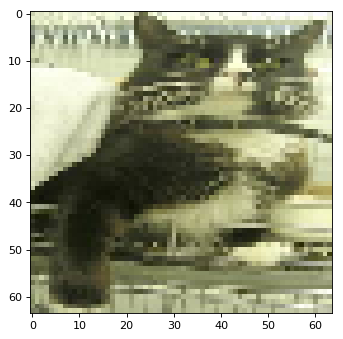

## Shown below are the 5 nearest perturbed images which were all classified as: cat

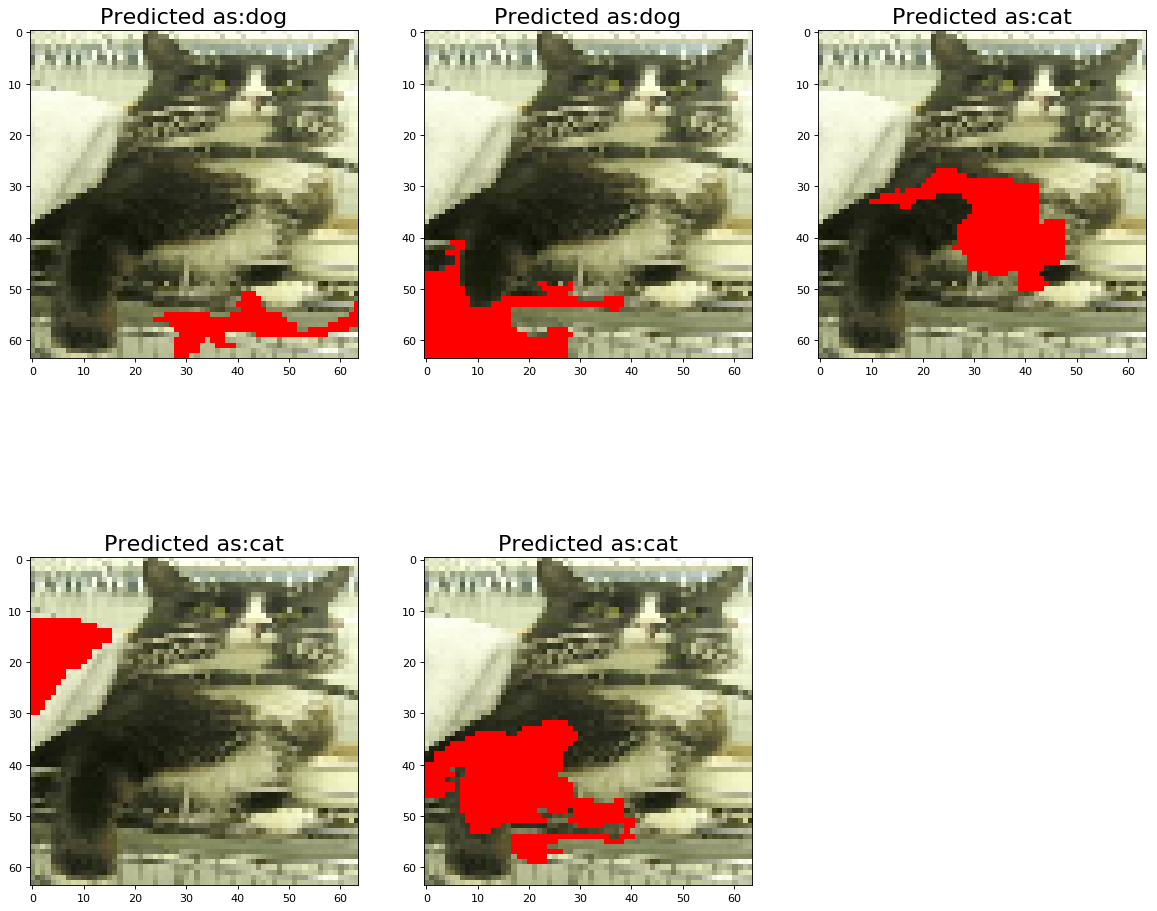

## The image is correctly classified as cat because of the long leg size

In [894]:
# plt.rcParams['figure.figsize'] = [100, 25]
fig=plt.figure(figsize=(10,5), dpi= 80)
printmd("## This image is classified as: "+prediction)
test_image_original = image.load_img('image_datasets/test_set/cats/cat.4007.jpg', target_size = (64, 64))
img_original = image.img_to_array(test_image_original)
imgplot = plt.imshow(img_original.astype(np.uint8))
plt.show()
fig=plt.figure(figsize=(18,16), dpi= 80)
printmd("## Shown below are the 5 nearest perturbed images which were all classified as: "+prediction)
# fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
for i in range(5):
    img = np.reshape(explanations[i],(64,64,3))
    result = classifier.predict(np.reshape(img,(1,64,64,3)))
    # training_set.class_indices
    if result[0][0] == 1:
        prediction = 'cat'
    else:
        prediction = 'dog'
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_title("Predicted as:"+prediction, fontsize=20)
    plt.imshow(img.astype(np.uint8))
plt.show()

printmd("## The image is correctly classified as cat because of the long leg size")
# printmd("## This shows that the background parts did not have any role in doing the prediction.")
#printmd("## Hence, our model predicted using the shape, which is correct!")
# printmd("## The mis-classification seems to be because of the color")

In [898]:
printmd("## Here, I consider another image")

## Here, I consider another image

In [899]:
printmd("## Step1: Find human-interpretable segments of the image")

## Step1: Find human-interpretable segments of the image

In [900]:
test_image1 = image.load_img('image_datasets/test_set/cats/cat.4162.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image1)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
if result[0][0] == 1:
    prediction = 'cat'
else:
    prediction = 'dog'

img_original = image.img_to_array(test_image1)

printmd("## The image is classified as a "+prediction)

segments_slic = slic(img_original, n_segments=30, compactness=0.01, sigma=1)

num_segments = np.max(segments_slic)
printmd("## Number of superpixels found in the image: "+str(num_segments))

## The image is classified as a dog

## Number of superpixels found in the image: 15

In [901]:
printmd("## Step2: Find the training data in vicnity using perturbations on the segments")

## Step2: Find the training data in vicnity using perturbations on the segments

In [903]:
instancePointIn3D = np.reshape(test_image,(64,64,3))
trainingDataIn3D = trainingDataInVicinity2(instancePointIn3D, num_segments, segments_slic)

In [904]:
printmd("## Step3: Find explanations on a test image by applying k-NN to the perturbed images")

## Step3: Find explanations on a test image by applying k-NN to the perturbed images

In [905]:
explanations = explainInstanceUsingKNN(originalClassifier=classifier,instancePoint=test_image,num_samples=num_segments,num_neighbors=5)

(1, 64, 64, 3)
[[0.]]
Nearest neighbor index: 2
Nearest neighbor index: 10
Nearest neighbor index: 8
Nearest neighbor index: 11
Nearest neighbor index: 12


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


## This image is classified as: dog

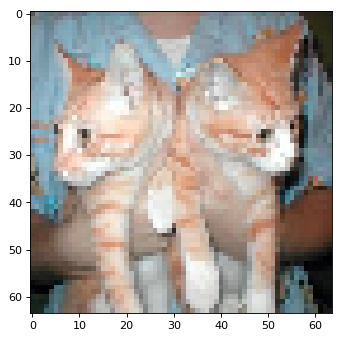

## Shown below are the 5 nearest perturbed images which were also classified as: dog

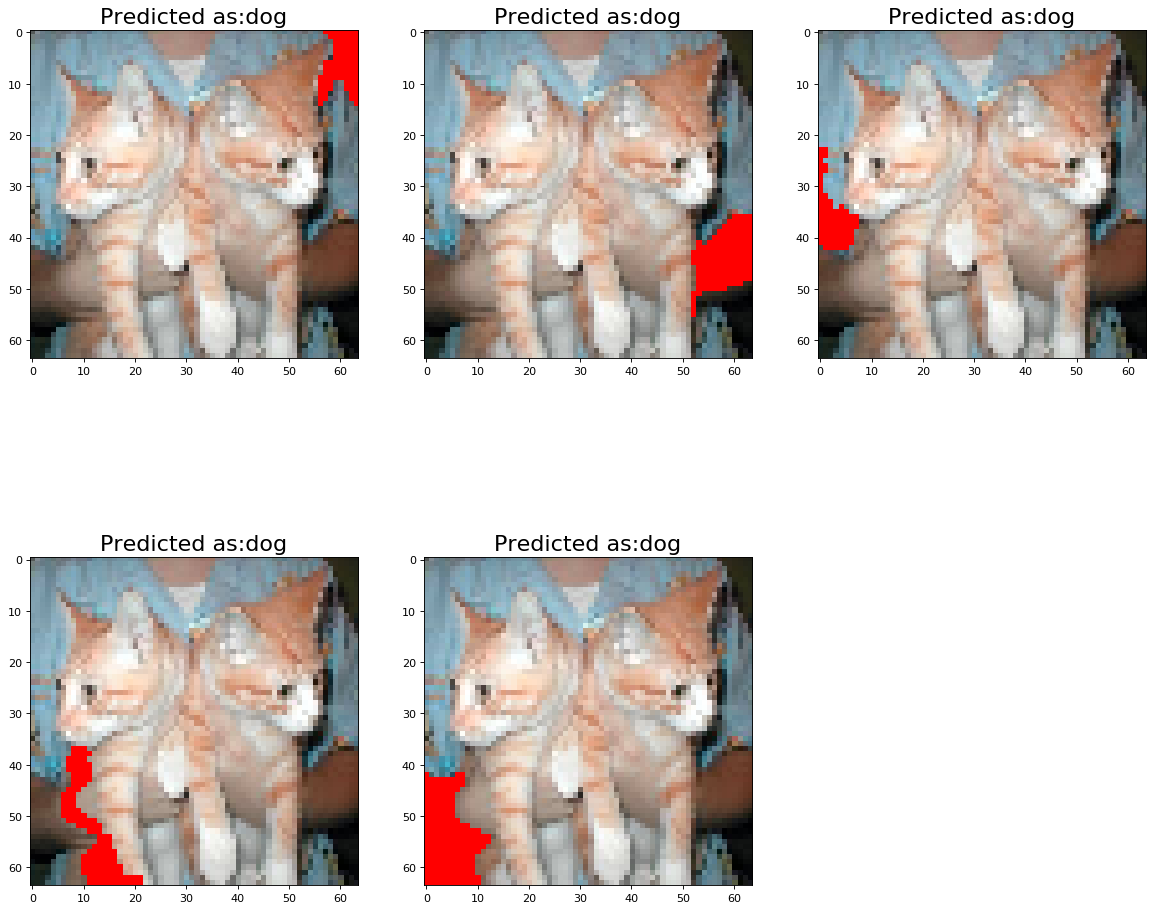

## The model misclassifies the given image as a dog. As you can see, removing the background also doesn't change the result

## Therefore, the target of the model was at correct position but it got confused with 2 cats shape

In [907]:
# plt.rcParams['figure.figsize'] = [100, 25]
fig=plt.figure(figsize=(10,5), dpi= 80)
printmd("## This image is classified as: "+prediction)
test_image_original = image.load_img('image_datasets/test_set/cats/cat.4162.jpg', target_size = (64, 64))
img_original = image.img_to_array(test_image_original)
imgplot = plt.imshow(img_original.astype(np.uint8))
plt.show()
printmd("## Shown below are the 5 nearest perturbed images which were also classified as: "+prediction)
fig=plt.figure(figsize=(18,16), dpi= 80)
# fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
for i in range(5):
    img = np.reshape(explanations[i],(64,64,3))
    result = classifier.predict(np.reshape(img,(1,64,64,3)))
    # training_set.class_indices
    if result[0][0] == 1:
        prediction = 'cat'
    else:
        prediction = 'dog'
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_title("Predicted as:"+prediction,fontsize=20)
    plt.imshow(img.astype(np.uint8))
plt.show()

printmd("## The model misclassifies the given image as a dog. As you can see, removing the background also doesn't change the result")
printmd("## Therefore, the target of the model was at correct position but it got confused with 2 cats shape")
# printmd("## This shows that the background parts did not have any role in doing the prediction.")
# printmd("## Hence, the model predicted using the shape, but it looks like it detected using the combined shape of 2 cats (i.e. from 2 ears)")
# printmd("## The model might fail if we want further information like number of cats. This shows the limitation of this model.")
# printmd("## The mis-classification seems to be because of the color")

In [908]:
printmd("## Step1: Find human-interpretable segments of the image")

## Step1: Find human-interpretable segments of the image

In [910]:
test_image1 = image.load_img('cat_human.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image1)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
if result[0][0] == 1:
    prediction = 'cat'
else:
    prediction = 'dog'


printmd("## The image is classified as a "+prediction)
img_original = image.img_to_array(test_image1)


segments_slic = slic(img_original, n_segments=25, compactness=0.01, sigma=1)

num_segments = np.max(segments_slic)
printmd("## Number of superpixels found in the image: "+str(num_segments))

## The image is classified as a cat

## Number of superpixels found in the image: 13

In [911]:
printmd("## Step2: Find the training data in vicnity using perturbations on the segments")

## Step2: Find the training data in vicnity using perturbations on the segments

In [913]:
instancePointIn3D = np.reshape(test_image,(64,64,3))
trainingDataIn3D = trainingDataInVicinity2(instancePointIn3D, num_segments, segments_slic)

In [914]:
printmd("## Step3: Find explanations on a test image by applying k-NN to the perturbed images")

## Step3: Find explanations on a test image by applying k-NN to the perturbed images

In [915]:
explanations = explainInstanceUsingKNN(originalClassifier=classifier,instancePoint=test_image,num_samples=num_segments,num_neighbors=5)

(1, 64, 64, 3)
[[1.]]
Nearest neighbor index: 9
Nearest neighbor index: 4
Nearest neighbor index: 10
Nearest neighbor index: 5
Nearest neighbor index: 12


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


## This image is classified as: cat

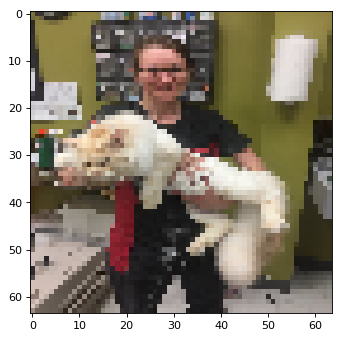

## Shown below are the the 5 nearest perturbed images which were classified as a cat

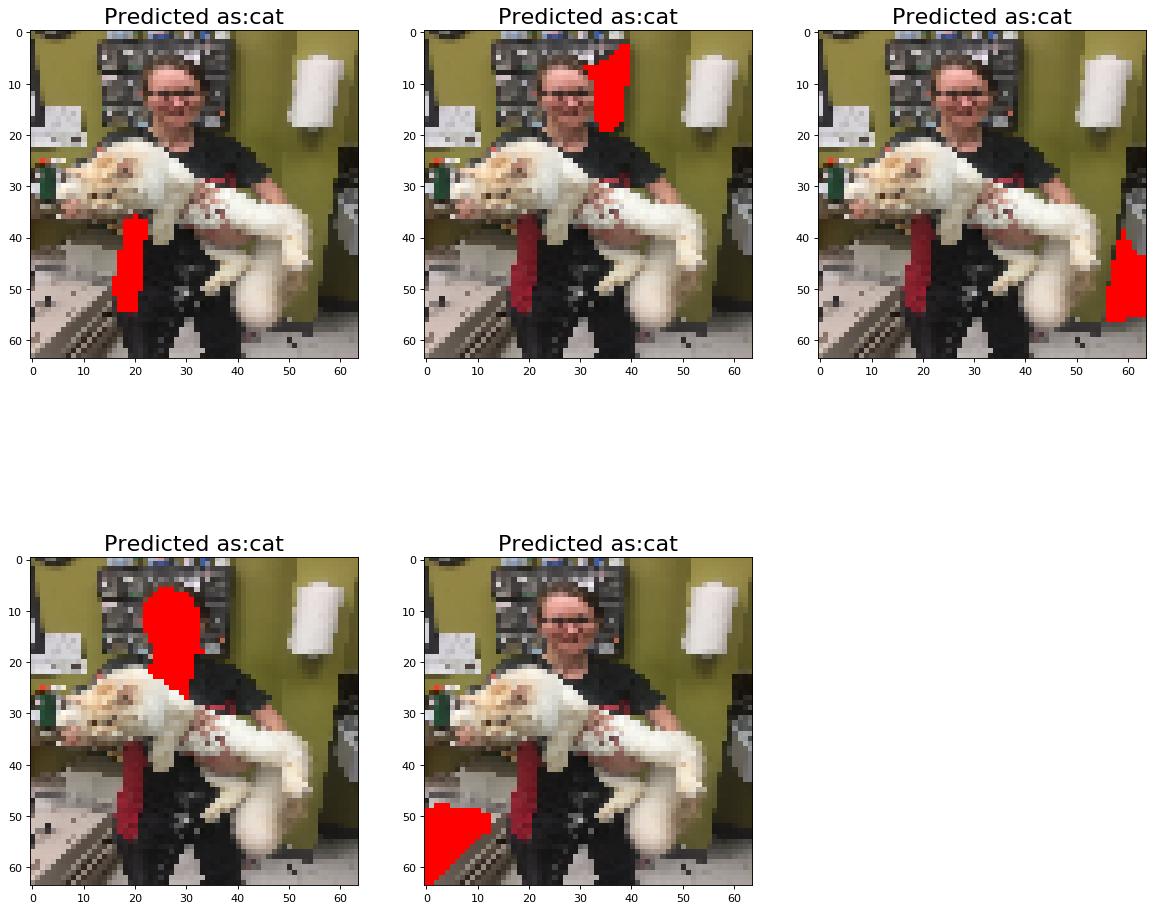

## This image is correctly classified as cat. As we can see that even though we remove the face, it is still a cat. Therefore, the model used the correct features to classify the image.

In [918]:
# plt.rcParams['figure.figsize'] = [100, 25]
fig=plt.figure(figsize=(10,5), dpi= 80)
printmd("## This image is classified as: "+prediction)
test_image_original = image.load_img('cat_human.jpg', target_size = (64, 64))
img_original = image.img_to_array(test_image_original)
imgplot = plt.imshow(img_original.astype(np.uint8))
plt.show()
printmd("## Shown below are the the 5 nearest perturbed images which were classified as a cat")
fig=plt.figure(figsize=(18,16), dpi= 80)
# fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
for i in range(5):
    img = np.reshape(explanations[i],(64,64,3))
    result = classifier.predict(np.reshape(img,(1,64,64,3)))
    # training_set.class_indices
    if result[0][0] == 1:
        prediction = 'cat'
    else:
        prediction = 'dog'
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_title("Predicted as:"+prediction,fontsize=20)
    plt.imshow(img.astype(np.uint8))
plt.show()


printmd("## This image is correctly classified as cat. As we can see that even though we remove the face, it is still a cat. Therefore, the model used the correct features to classify the image.")
# printmd("## Hence, our model predicted using the shape, but did not consider colors. This shows the limitation of this model.")
# printmd("## The mis-classification seems to be because of the color")